# soft-brownian-offsetのお試し

参考URL
[soft\-brownian\-offset](https://pypi.org/project/sbo/)

In [2]:
from sklearn.datasets import make_moons
from sbo import soft_brownian_offset,gaussian_hyperspheric_offset
import numpy as np

import matplotlib.pyplot as plt


In [3]:
X, _ = make_moons(n_samples=120, noise=.08)

X_sbo = soft_brownian_offset(X, d_min=.35, d_off=.24, n_samples=320, softness=.2)

X_hbo = soft_brownian_offset(X, d_min=.35, d_off=.24, n_samples=320, softness=0)

X_gho = (gaussian_hyperspheric_offset(n_samples=320, mu=2, std=.3, n_dim=X.ndim) + X.mean()) * X.std()




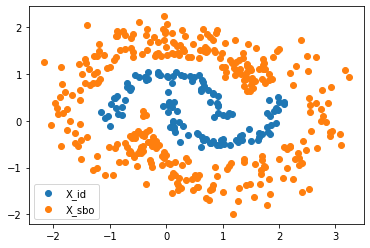

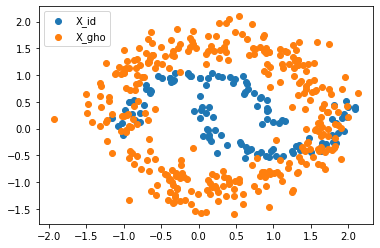

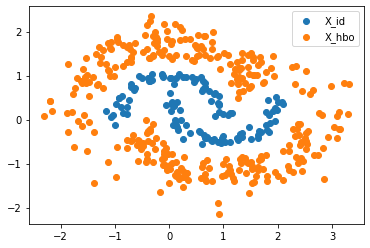

In [4]:
plt.scatter(X[:,0],X[:,1],label='X_id')
# plt.scatter(X_gho[:,0],X_gho[:,1],label='X_gho')
plt.scatter(X_sbo[:,0],X_sbo[:,1],label='X_sbo')
plt.legend()
plt.show()

plt.scatter(X[:,0],X[:,1],label='X_id')
plt.scatter(X_gho[:,0],X_gho[:,1],label='X_gho')
# plt.scatter(X_sbo[:,0],X_sbo[:,1],label='X_sbo')
plt.legend()
plt.show()

plt.scatter(X[:,0],X[:,1],label='X_id')
plt.scatter(X_hbo[:,0],X_hbo[:,1],label='X_hbo')
plt.legend()
plt.show()

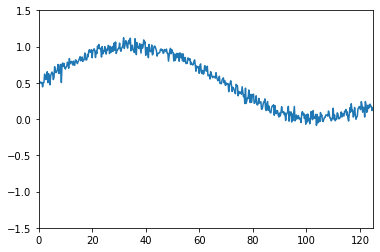

1.3131043204821842
-5.402193797696436


In [5]:
a = 1     #振幅
fs = 44100 #サンプリング周波数
f0 = 440  #周波数(ラの音にあたります)
sec = 5   #秒

var = 35
std = np.sqrt(var)
f = 35*np.random.randn()

eps = np.sqrt(0.1)*np.random.randn()

X_sins = []
for i in range(2000):
    X_sin=[]
    for n in np.arange(500):
        # f0 = np. 
        epsilon = np.sqrt(0.01)*np.random.randn()
        # s = a * np.sin(2.0 * np.pi * f * n) + epsilon
        s = a * np.sin(2.0 * np.pi * 0.0072 * (125/500) * n) + epsilon
        s = (s+1)/2
        X_sin.append(s)
    X_sins.append(X_sin)
    # np.append(X_sins, X_sin, axis=0)

t = np.arange(0, len(X_sin))/4

plt.plot(t,X_sin)
plt.xlim([0, 125])#範囲指定0秒〜0.01秒
plt.ylim([-1.5, 1.5])#範囲指定0秒〜0.01秒
plt.show()

# print(t)
print(35*np.random.randn())
print(np.sqrt(35)*np.random.randn())
# print((35*np.random.randn())/16)
# print((np.sqrt(35)*np.random.randn())/16)

X_sin = np.array(X_sin)
X_sins = np.array(X_sins)
X_sin_teach = np.ones(len(X_sins))


In [6]:
# VAE作る
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch import optim
import torch.utils as utils
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, TensorDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [7]:
batch_size = 1
train_set = TensorDataset(torch.from_numpy(X_sins), torch.from_numpy(X_sin_teach))

# データセットをbatch_size個のデータごとに小分けにしたものにして、ミニバッチ学習が可能なようにします。
# shuffle=True　にすると画像の順序がランダムになったりしますが、ここらへんはどっちでもいいと思います。
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=False)


In [8]:
class VAE(nn.Module): # nn.Moduleクラスを引き継ぎ
    def __init__(self, z_dim, x_dim):
        super(VAE, self).__init__()
        self.x_dim = x_dim
        self.z_dim = z_dim
        
        # エンコーダー用の関数
        self.fc1 = nn.Linear(x_dim, 64)
        self.fc2 = nn.Linear(64, 48)
        self.fc3 = nn.Linear(48, 32)
        self.fc4_mean = nn.Linear(32, z_dim)
        self.fc4_var = nn.Linear(32, z_dim)

        # self.fc2_mean = nn.Linear(20, z_dim)
        # self.fc2_var = nn.Linear(20, z_dim)
        # デコーダー用の関数
        self.fc5 = nn.Linear(z_dim, 32)
        self.fc6 = nn.Linear(32, 48)
        self.fc7 = nn.Linear(48, 120)
        self.fc8 = nn.Linear(120, x_dim)

    # エンコーダー
    def encoder(self, x):
        # x = x.view(-1, self.x_dim)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        mean = self.fc4_mean(x) # 平均
        log_var = self.fc4_var(x) # 分散の対数
        return mean, log_var

    # デコーダー
    def decoder(self, z):
        y = F.relu(self.fc5(z))
        y = F.relu(self.fc6(y))
        y = F.relu(self.fc7(y))
        y = torch.sigmoid(self.fc8(y))
        # y = self.fc8(y)
        # y = F.relu(self.fc8(y))
        # y = torch.sigmoid(self.fc8(y))
        # y = torch.sigmoid(self.fc4(y)) # 各要素にシグモイド関数を適用し、値を(0,1)の範囲に
        return y

    # 潜在ベクトルのサンプリング(再パラメータ化)
    def reparametrizaion(self, mean, log_var, device):
        epsilon = torch.randn(mean.shape, device=device)
        return mean + epsilon*torch.exp(0.5 * log_var)


    def forward(self, x, device):
        # x = x.view(-1, self.x_dim)
        mean, log_var = self.encoder(x) # 画像xを入力して、平均・分散を出力
        KL = 0.5 * torch.sum(1+log_var - mean**2 - torch.exp(log_var)) # KL[q(z|x)||p(z)]を計算
        z = self.reparametrizaion(mean, log_var, device) # 潜在ベクトルをサンプリング(再パラメータ化)
        x_hat = self.decoder(z) # 潜在ベクトルを入力して、再構築画像 y を出力
        reconstruction = torch.sum(x * torch.log(x_hat+1e-8) + (1 - x) * torch.log(1 - x_hat  + 1e-8)) #E[log p(x|z)]
        lower_bound = -(KL + reconstruction) #変分下界(ELBO)=E[log p(x|z)] - KL[q(z|x)||p(z)]
        return lower_bound , z, x_hat

In [9]:
# dataloader_train, _ = setup_data_loaders(batch_size=32) # データローダーを作成
dataloader_train = train_loader
model = VAE(z_dim = 20, x_dim=500).to(device) # モデルをインスタンス化し、GPUにのせる
optimizer = optim.Adam(model.parameters(), lr=1e-3) # オプティマイザーの設定
model.train() # モデルを訓練モードに
num_epochs = 10
loss_list = []
for i in range(num_epochs):
    losses = []
    for x, t in dataloader_train: # データローダーからデータを取り出す。
        x = x.to(device) # データをGPUにのせる
        x = x.float()
        loss, z, y = model(x, device) # 損失関数の値 loss 、潜在ベクトル z 、再構築画像 y を出力
        model.zero_grad() # モデルの勾配を初期化
        loss.backward() # モデル内のパラメータの勾配を計算
        optimizer.step() # 最適化を実行
        losses.append(loss.cpu().detach().numpy()) # ミニバッチの損失を記録
    loss_list.append(np.average(losses)) # バッチ全体の損失を登録
    print("EPOCH: {} loss: {}".format(i, np.average(losses)))

EPOCH: 0 loss: 183.10440063476562
EPOCH: 1 loss: 179.92160034179688
EPOCH: 2 loss: 179.8563690185547
EPOCH: 3 loss: 179.80606079101562
EPOCH: 4 loss: 179.76556396484375
EPOCH: 5 loss: 179.73362731933594
EPOCH: 6 loss: 179.70599365234375
EPOCH: 7 loss: 179.69171142578125
EPOCH: 8 loss: 179.67547607421875
EPOCH: 9 loss: 179.66387939453125


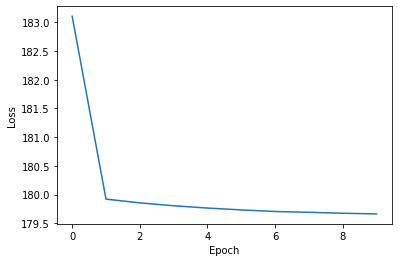

In [10]:
plt.plot(range(len(loss_list)), loss_list)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

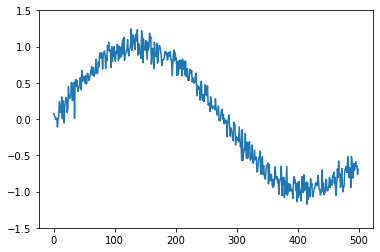

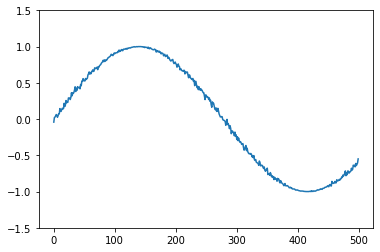

tensor([0.5376, 0.5229, 0.5161, 0.4969, 0.5031, 0.5072, 0.4450, 0.4974, 0.5069,
        0.6209], device='cuda:0')
tensor([0.4790, 0.5107, 0.5141, 0.5216, 0.5315, 0.5263, 0.5124, 0.5231, 0.5366,
        0.5365], device='cuda:0', grad_fn=<SliceBackward>)


In [13]:
model.eval()

plt.plot( ((x[0]*2)-1).detach().cpu().numpy())
plt.ylim([-1.5, 1.5])#範囲指定0秒〜0.01秒
plt.show()


_, _, y = model(x[0].float().to(device), device)
plt.plot( ((y*2)-1).detach().cpu().numpy())
plt.ylim([-1.5, 1.5])#範囲指定0秒〜0.01秒
plt.show()

print(x[0][:10])
print(y[:10])
